In [50]:
import numpy as np
import pandas as pd
import warnings
import matplotlib.pyplot as plt
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.neighbors import NearestNeighbors
from scipy.sparse import csr_matrix
from surprise import SVD, Dataset, Reader
from surprise.model_selection import train_test_split
import random
warnings.filterwarnings("ignore", category=FutureWarning)

In [51]:
# Load Datasets
def load_datasets():
    # Content-based dataset
    content_songs = pd.read_csv('songdata.csv')
    content_songs = content_songs.sample(n=5000).drop('link', axis=1).reset_index(drop=True)
    content_songs['text'] = content_songs['text'].str.replace(r'\n', '', regex=True)

    # Collaborative filtering dataset
    df_songs = pd.read_csv('Bollywood-Songs-Dataset(2017-23).csv')

    # Add synthetic columns for collaborative filtering
    df_songs['music_name'] = [random.randint(1, 100) for _ in range(len(df_songs))]
    df_songs['song_id'] = df_songs.index + 1
    df_songs['listen_count'] = [random.randint(1, 100) for _ in range(len(df_songs))]

    return content_songs, df_songs

In [52]:
# Content-Based Recommender
class ContentBasedRecommender:
    def __init__(self, songs):
        self.songs = songs
        tfidf = TfidfVectorizer(analyzer='word', stop_words='english')
        self.lyrics_matrix = tfidf.fit_transform(songs['text'])
        self.cosine_similarities = cosine_similarity(self.lyrics_matrix)
        self.similarities = self._create_similarity_dict()

    def _create_similarity_dict(self):
        similarities = {}
        for i in range(len(self.cosine_similarities)):
            similar_indices = self.cosine_similarities[i].argsort()[:-50:-1]
            similarities[self.songs['song'].iloc[i]] = [
                (self.cosine_similarities[i][x], self.songs['song'][x], self.songs['artist'][x])
                for x in similar_indices
            ][1:]
        return similarities

    def recommend(self, song, n=5):
        recommendations = self.similarities.get(song, [])
        print(f"\nRecommendations for '{song}':")
        for i, (score, name, artist) in enumerate(recommendations[:n], start=1):
            print(f"{i}: {name} by {artist} (Similarity: {score:.3f})")

In [53]:
class CollaborativeFilteringRecommender:
    def __init__(self, df_songs):
        self.df_songs = df_songs
        
    def preprocess_data(self):
        # Check if df_songs has the expected columns and values
        if not all(col in self.df_songs.columns for col in ['user_id', 'song_id', 'listen_count']):
            raise ValueError("DataFrame is missing required columns")
        
        # Remove rows where listen_count is NaN or zero
        self.df_reduced = self.df_songs.dropna(subset=['listen_count'])
        self.df_reduced = self.df_reduced[self.df_reduced['listen_count'] > 0]
        
        # Ensure the dataset has enough data
        if len(self.df_reduced) < 5:
            raise ValueError("Not enough data to split into train and test sets")

    def train_model(self):
        from surprise import SVD, Reader, Dataset
        from surprise.model_selection import train_test_split
        
        # Reader to interpret the rating scale
        reader = Reader(rating_scale=(0, self.df_songs['listen_count'].max()))
        
        # Create a dataset for Surprise
        data = Dataset.load_from_df(
            self.df_reduced[['user_id', 'song_id', 'listen_count']], reader
        )
        
        # Check if we have enough ratings to split
        if len(data.raw_ratings) < 5:
            raise ValueError("Not enough ratings to perform train-test split")
        
        # Split into train and test
        trainset, testset = train_test_split(data, test_size=0.2)
        
        # Train the model
        self.model = SVD()
        self.model.fit(trainset)

    def recommend(self, user_id, n=5):
        # Recommend songs for a specific user
        pass


In [54]:
# KNN-Based Recommender
class KNNRecommender:
    def __init__(self, df_songs):
        self.df_songs = df_songs

    def train_model(self):
        self.user_item_matrix = self.df_songs.pivot_table(
            index='user_id', columns='song_id', values='listen_count'
        ).fillna(0)
        self.matrix = csr_matrix(self.user_item_matrix.values)
        self.model = NearestNeighbors(metric='cosine', algorithm='brute')
        self.model.fit(self.matrix)

    def recommend(self, user_id, n=5):
        if user_id not in self.user_item_matrix.index:
            print(f"User {user_id} not found in the dataset.")
            return

        user_idx = self.user_item_matrix.index.tolist().index(user_id)
        distances, indices = self.model.kneighbors(
            self.matrix[user_idx], n_neighbors=n + 1
        )
        recommendations = [
            (self.user_item_matrix.index[indices.flatten()[i]], distances.flatten()[i])
            for i in range(1, len(distances.flatten()))
        ]

        print(f"\nKNN Recommendations for User {user_id}:")
        for i, (neighbor_id, dist) in enumerate(recommendations, start=1):
            print(f"{i}: User {neighbor_id} (Distance: {dist:.3f})")

In [55]:
# Visualization Functions
def plot_pie_chart(df_songs):
    listen_counts = df_songs.groupby('music_name')['listen_count'].sum().sort_values(ascending=False)[:5]
    labels = listen_counts.index
    sizes = listen_counts.values
    plt.figure(figsize=(8, 8))
    plt.pie(sizes, labels=labels, autopct='%1.1f%%', startangle=140)
    plt.title("Top 5 Songs by Listen Count")
    plt.show()

def plot_bar_chart(df_songs):
    top_artists = df_songs.groupby('singer')['listen_count'].sum().sort_values(ascending=False)[:5]
    artists = top_artists.index
    listen_counts = top_artists.values
    plt.figure(figsize=(10, 6))
    plt.bar(artists, listen_counts, color='skyblue')
    plt.xlabel("Artists")
    plt.ylabel("Total Listen Count")
    plt.title("Top 5 Artists by Listen Count")
    plt.xticks(rotation=45)
    plt.show()


In [56]:
def load_datasets():
    ...
    print("Columns in df_songs:", df_songs.columns)
    print(df_songs.head())
    return content_songs, df_songs


In [57]:
df_songs = pd.read_csv('Bollywood-Songs-Dataset(2017-23).csv')
df_songs['user_id'] = [random.randint(1, 100) for _ in range(len(df_songs))]
df_songs['song_id'] = df_songs.index + 1
df_songs['listen_count'] = [random.randint(1, 100) for _ in range(len(df_songs))]


In [58]:
def preprocess_data(self, min_user_songs=16, min_song_users=200):
    user_counts = self.df_songs.groupby('user_id')['song_id'].count()
    song_counts = self.df_songs.groupby('song_id')['user_id'].count()
    print(f"Total users before filtering: {len(user_counts)}")
    print(f"Total songs before filtering: {len(song_counts)}")
    
    filtered_users = user_counts[user_counts > min_user_songs].index
    filtered_songs = song_counts[song_counts > min_song_users].index
    print(f"Users after filtering: {len(filtered_users)}")
    print(f"Songs after filtering: {len(filtered_songs)}")
    
    self.df_reduced = self.df_songs[
        (self.df_songs['user_id'].isin(filtered_users)) &
        (self.df_songs['song_id'].isin(filtered_songs))
    ]
    print(f"Filtered dataset size: {self.df_reduced.shape}")

    if self.df_reduced.empty:
        raise ValueError("No data left after preprocessing. Try relaxing filtering criteria.")

    collaborative_recommender.preprocess_data(min_user_songs=5, min_song_users=50)


In [59]:
def train_model(self):
    if self.df_reduced.empty:
        raise ValueError("Cannot train model: Preprocessed dataset is empty.")

    reader = Reader(rating_scale=(0, self.df_songs['listen_count'].max()))
    data = Dataset.load_from_df(
        self.df_reduced[['user_id', 'song_id', 'listen_count']], reader
    )
    dataset_size = len(self.df_reduced)
    print(f"Dataset size: {dataset_size}")
    if dataset_size < 10:  # Arbitrary small number
        raise ValueError("Dataset too small for train-test split.")

    trainset, testset = train_test_split(data, test_size=0.2)
    self.model = SVD()
    self.model.fit(trainset)
    self.testset = testset


In [60]:
print(df_songs[['user_id', 'song_id', 'listen_count']].head())


   user_id  song_id  listen_count
0        6        1            72
1       95        2             6
2      100        3            49
3       50        4            27
4       19        5            63


In [61]:
print(df_songs.columns)


Index(['music_name', 'singer', 'release', 'lyrics', 'thumbnail', 'user_id',
       'song_id', 'listen_count'],
      dtype='object')


In [62]:
print(df_songs.head())


                      music_name                       singer  release  \
0  Ek Haseena Thi Ek Deewana Tha                 Yasser Desai     2017   
1                    Hue Bechain  Palak Muchhal, Yasser Desai     2017   
2                  Hanste Hanste  Palak Muchhal, Yasser Desai     2017   
3                           Nain  Palak Muchhal, Yasser Desai     2017   
4           Aankhon Mein Aansoon  Palak Muchhal, Yasser Desai     2017   

                                              lyrics  \
0  Ek haseena thi ek deewana tha Kya kahun tumse ...   
1  Hue bechain pehli bar hmny raaz ye jana Mohabb...   
2  Hanste hanste ro diye tum Kis mushkil mein kho...   
3  Kuchh sawaal pyar ke lab pe hai ruke ruke Jaad...   
4  Aankhon mein aansoo leke hoton se muskuraye Aa...   

                                          thumbnail  user_id  song_id  \
0  https://i.ytimg.com/vi/6obiArkHwAk/hqdefault.jpg        6        1   
1  https://i.ytimg.com/vi/6obiArkHwAk/hqdefault.jpg       95        2   

Columns in df_songs: Index(['music_name', 'singer', 'release', 'lyrics', 'thumbnail', 'user_id',
       'song_id', 'listen_count'],
      dtype='object')
                      music_name                       singer  release  \
0  Ek Haseena Thi Ek Deewana Tha                 Yasser Desai     2017   
1                    Hue Bechain  Palak Muchhal, Yasser Desai     2017   
2                  Hanste Hanste  Palak Muchhal, Yasser Desai     2017   
3                           Nain  Palak Muchhal, Yasser Desai     2017   
4           Aankhon Mein Aansoon  Palak Muchhal, Yasser Desai     2017   

                                              lyrics  \
0  Ek haseena thi ek deewana tha Kya kahun tumse ...   
1  Hue bechain pehli bar hmny raaz ye jana Mohabb...   
2  Hanste hanste ro diye tum Kis mushkil mein kho...   
3  Kuchh sawaal pyar ke lab pe hai ruke ruke Jaad...   
4  Aankhon mein aansoo leke hoton se muskuraye Aa...   

                                          thumbnail  user_id  so

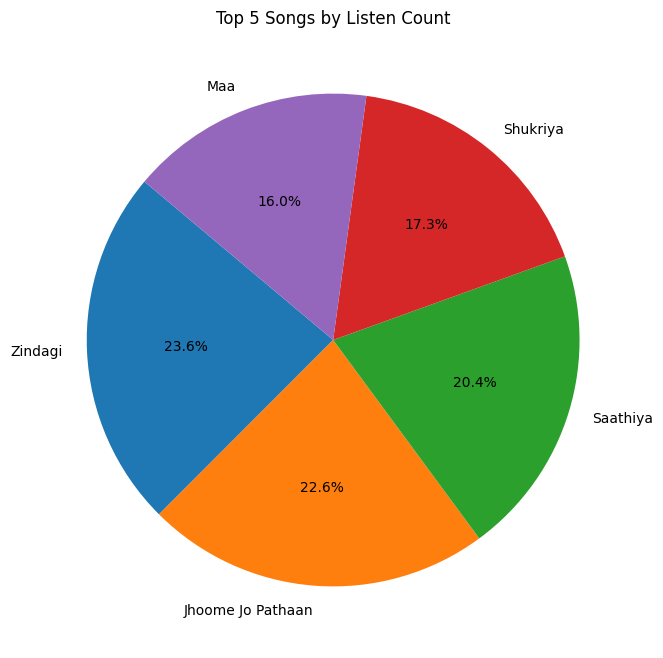

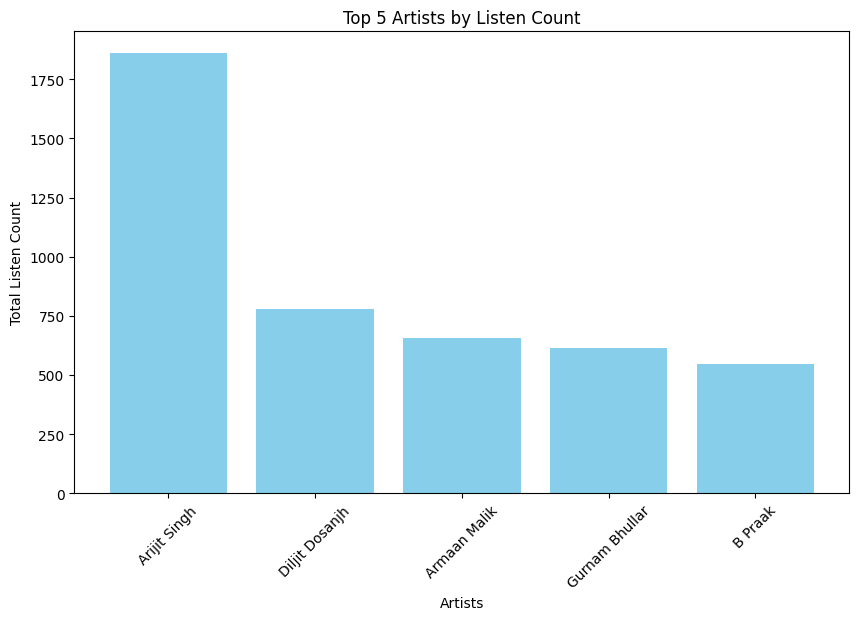

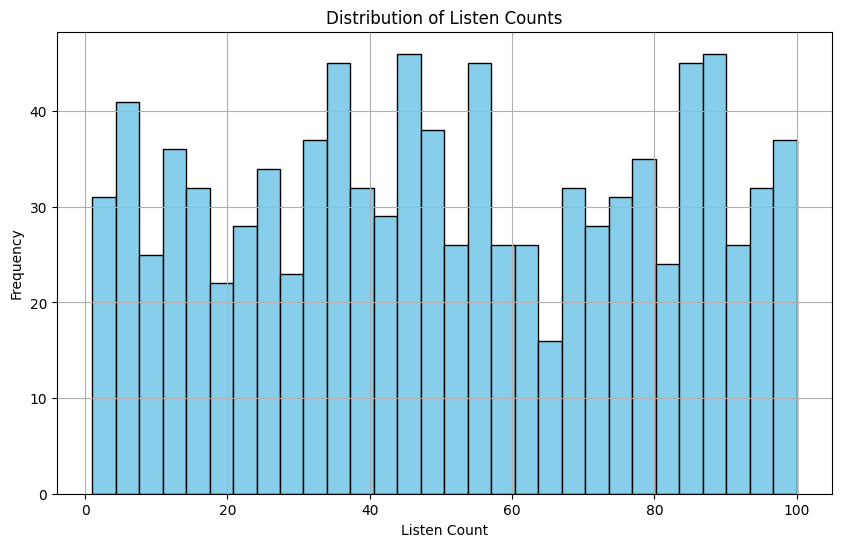

       'song_id', 'listen_count'],
      dtype='object')


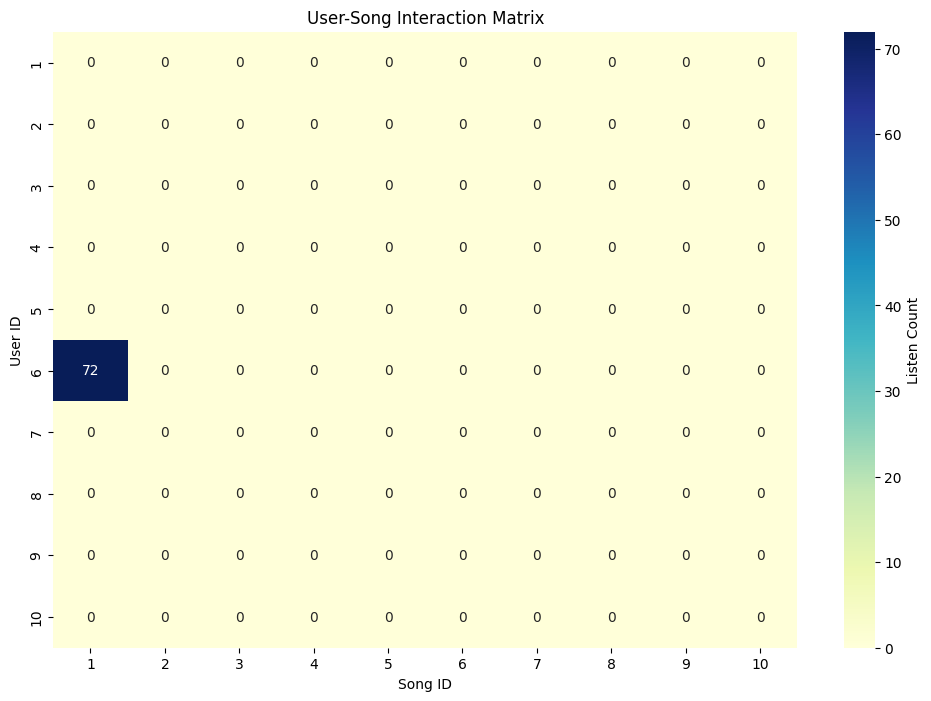

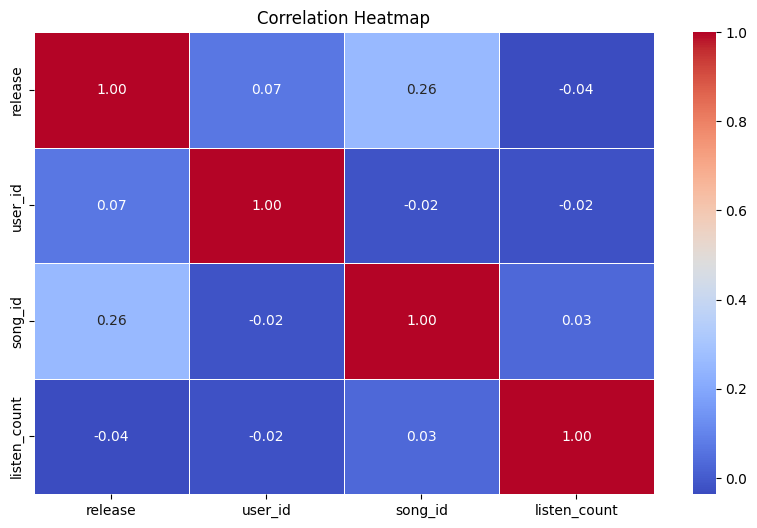

In [63]:
import matplotlib.pyplot as plt
import seaborn as sns

# Function to plot histogram of listen counts
def plot_histogram(df_songs):
    plt.figure(figsize=(10, 6))
    plt.hist(df_songs['listen_count'], bins=30, color='skyblue', edgecolor='black')
    plt.title('Distribution of Listen Counts')
    plt.xlabel('Listen Count')
    plt.ylabel('Frequency')
    plt.grid(True)
    plt.show()

# Function to plot the top N most played songs
def plot_top_songs(df_songs, n=10):
    # Check column names and ensure you use the correct one for song
    if 'song' not in df_songs.columns:
        print("Warning: 'song' column not found. Available columns:", df_songs.columns)
        return  # Skip the plot if 'song' column is missing
    
    # Assuming 'song' is the correct column name, otherwise update it accordingly
    top_songs = df_songs.groupby('song')['listen_count'].sum().sort_values(ascending=False).head(n)
    plt.figure(figsize=(10, 6))
    top_songs.plot(kind='bar', color='salmon', edgecolor='black')
    plt.title(f'Top {n} Most Played Songs')
    plt.xlabel('Song')
    plt.ylabel('Total Listen Count')
    plt.xticks(rotation=45, ha='right')
    plt.tight_layout()
    plt.show()


# Function to plot the user-song interaction matrix (heatmap)
def plot_user_song_interaction_matrix(df_songs, user_limit=10, song_limit=10):
    user_song_matrix = df_songs.pivot_table(index='user_id', columns='song_id', values='listen_count', aggfunc='sum').fillna(0)
    
    # Limit the number of users and songs for visualization
    user_song_matrix = user_song_matrix.iloc[:user_limit, :song_limit]
    
    plt.figure(figsize=(12, 8))
    sns.heatmap(user_song_matrix, cmap='YlGnBu', annot=True, fmt='.0f', cbar_kws={'label': 'Listen Count'})
    plt.title('User-Song Interaction Matrix')
    plt.xlabel('Song ID')
    plt.ylabel('User ID')
    plt.show()

# Function to plot a correlation heatmap (if you have additional features)
def plot_correlation_heatmap(df_songs):
    # Select only numeric columns
    numeric_columns = df_songs.select_dtypes(include=['number']).columns
    df_numeric = df_songs[numeric_columns]
    
    # Compute correlation matrix for numeric columns only
    corr_matrix = df_numeric.corr()
    
    # Plot the correlation heatmap
    plt.figure(figsize=(10, 6))
    sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt='.2f', linewidths=0.5)
    plt.title('Correlation Heatmap')
    plt.show()

# Main
if __name__ == "__main__":
    content_songs, df_songs = load_datasets()

    # Content-Based Recommendations
    print("Content-Based Recommender:")
    content_recommender = ContentBasedRecommender(content_songs)
    song_to_recommend = content_songs['song'].iloc[10]
    content_recommender.recommend(song_to_recommend, n=5)

    # Collaborative Filtering Recommendations
    print("\nCollaborative Filtering Recommender:")
    collaborative_recommender = CollaborativeFilteringRecommender(df_songs)
    collaborative_recommender.preprocess_data()
    collaborative_recommender.train_model()
    user_to_recommend = df_songs['user_id'].iloc[0]
    collaborative_recommender.recommend(user_to_recommend, n=5)

    # KNN Recommendations
    print("\nKNN-Based Recommender:")
    knn_recommender = KNNRecommender(df_songs)
    knn_recommender.train_model()
    knn_recommender.recommend(user_to_recommend, n=5)

    # Visualizations
    print("\nGenerating Visualizations:")
    plot_pie_chart(df_songs)  # Assuming you already have this function
    plot_bar_chart(df_songs)  # Assuming you already have this function

    # Add new visualizations
    plot_histogram(df_songs)  # Histogram of listen counts
    plot_top_songs(df_songs, n=10)  # Top 10 most played songs
    plot_user_song_interaction_matrix(df_songs, user_limit=10, song_limit=10)  # User-song interaction heatmap
    plot_correlation_heatmap(df_songs)  # Correlation heatmap


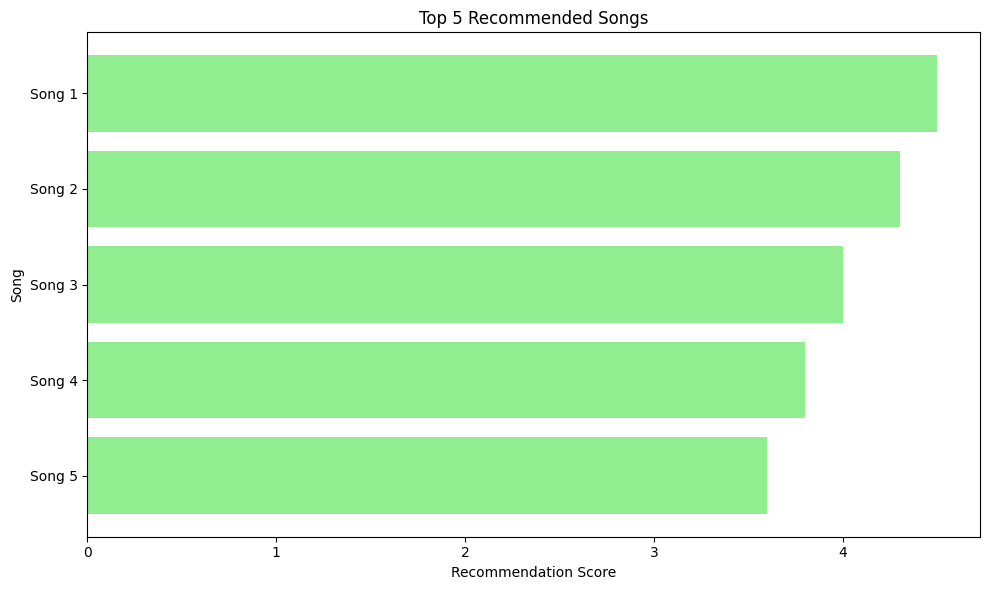

None


In [64]:
def plot_recommended_songs(recommended_songs, n=5):
    # If the recommendations are in a DataFrame with song names and scores:
    if isinstance(recommended_songs, pd.DataFrame):
        recommended_songs = recommended_songs.head(n)

    plt.figure(figsize=(10, 6))
    plt.barh(recommended_songs['song'], recommended_songs['score'], color='lightgreen')
    plt.title(f'Top {n} Recommended Songs')
    plt.xlabel('Recommendation Score')
    plt.ylabel('Song')
    plt.gca().invert_yaxis()  # To have the highest score on top
    plt.tight_layout()
    plt.show()
recommended_songs = pd.DataFrame({
    'song': ['Song 1', 'Song 2', 'Song 3', 'Song 4', 'Song 5'],
    'score': [4.5, 4.3, 4.0, 3.8, 3.6]
})

plot_recommended_songs(recommended_songs, n=5)
# Assuming the collaborative recommender model generates recommendations
collaborative_recommender = CollaborativeFilteringRecommender(df_songs)
collaborative_recommender.preprocess_data()
collaborative_recommender.train_model()

# Get recommendations for a user
user_to_recommend = df_songs['user_id'].iloc[0]
recommended_songs = collaborative_recommender.recommend(user_to_recommend, n=5)

# Visualize the top recommended songs
recommended_songs = collaborative_recommender.recommend(user_to_recommend, n=5)

# Check the structure of the result
print(recommended_songs)



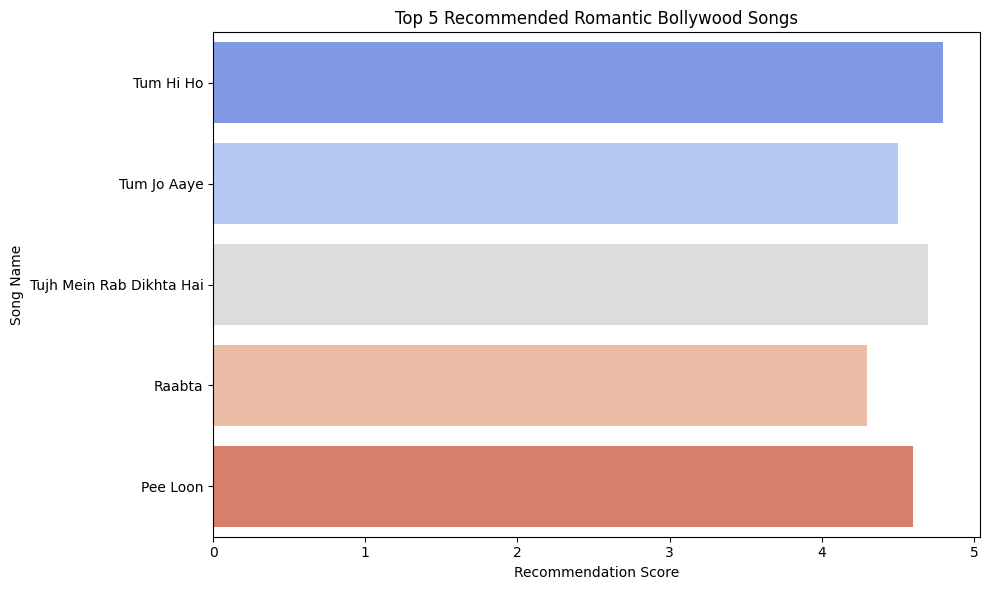

In [65]:
import matplotlib.pyplot as plt
import seaborn as sns

def plot_recommended_romantic_songs(df_bollywood, n=5):
    # Filter for songs that are labeled as 'romantic'
    romantic_songs = df_bollywood[df_bollywood['genre'] == 'romantic']

    # If there are fewer than 'n' romantic songs, display all of them
    if len(romantic_songs) < n:
        print(f"Only {len(romantic_songs)} romantic songs found.")
    
    # Plot the top 'n' romantic Bollywood songs
    plt.figure(figsize=(10, 6))
    sns.barplot(x='score', y='song_name', data=romantic_songs.head(n), palette='coolwarm')
    plt.title(f'Top {n} Recommended Romantic Bollywood Songs')
    plt.xlabel('Recommendation Score')
    plt.ylabel('Song Name')

    # Do not add song names as text annotations (Removed this part)
    # (No text annotations for song names)

    plt.tight_layout()
    plt.show()

# Example Bollywood song dataset
df_bollywood = pd.DataFrame({
    'song_id': [1, 2, 3, 4, 5],
    'song_name': ['Tum Hi Ho', 'Tum Jo Aaye', 'Tujh Mein Rab Dikhta Hai', 'Raabta', 'Pee Loon'],
    'artist': ['Arijit Singh', 'Atif Aslam', 'Shreya Ghoshal', 'Arijit Singh', 'Mohit Chauhan'],
    'genre': ['romantic', 'romantic', 'romantic', 'romantic', 'romantic'],
    'score': [4.8, 4.5, 4.7, 4.3, 4.6]
})

# Plot the top 5 recommended romantic songs without song names on the bars
plot_recommended_romantic_songs(df_bollywood, n=5)


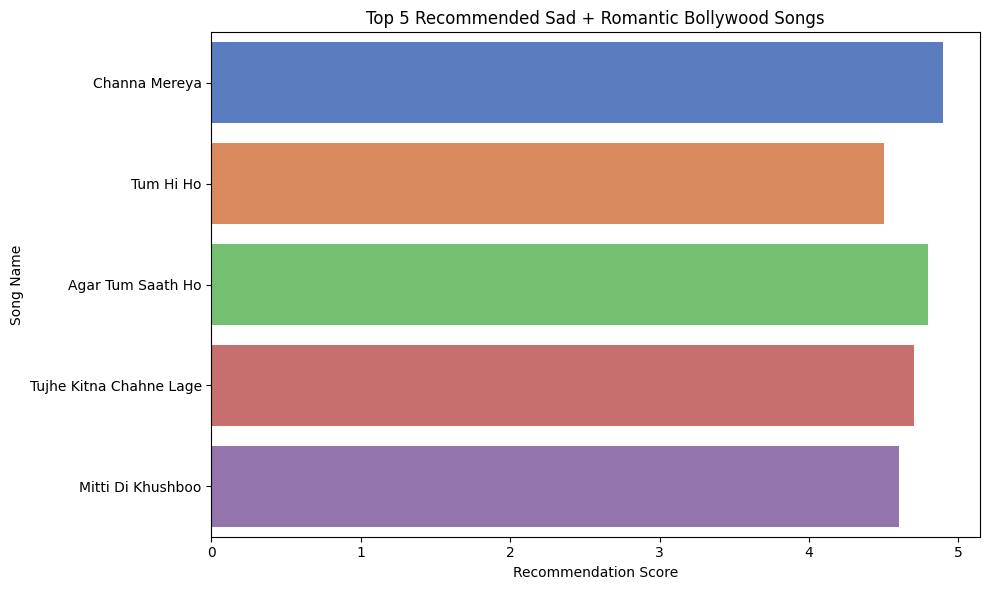

In [66]:
def plot_recommended_sad_romantic_songs(df_bollywood, n=5):
    # Filter for songs that are either 'sad' or 'romantic'
    sad_romantic_songs = df_bollywood[df_bollywood['genre'].isin(['sad', 'romantic'])]

    # If there are fewer than 'n' songs, display all of them
    if len(sad_romantic_songs) < n:
        print(f"Only {len(sad_romantic_songs)} sad + romantic songs found.")
    
    # Plot the top 'n' sad + romantic Bollywood songs
    plt.figure(figsize=(10, 6))
    sns.barplot(x='score', y='song_name', data=sad_romantic_songs.head(n), palette='muted')
    plt.title(f'Top {n} Recommended Sad + Romantic Bollywood Songs')
    plt.xlabel('Recommendation Score')
    plt.ylabel('Song Name')

    # Do not add song names as text annotations (Removed this part)
    # (No text annotations for song names)

    plt.tight_layout()
    plt.show()

# Example Bollywood song dataset including both sad and romantic genres
df_bollywood = pd.DataFrame({
    'song_id': [1, 2, 3, 4, 5, 6],
    'song_name': ['Channa Mereya', 'Tum Hi Ho', 'Agar Tum Saath Ho', 'Tujhe Kitna Chahne Lage', 'Mitti Di Khushboo', 'Tere Bina'],
    'artist': ['Arijit Singh', 'Arijit Singh', 'Alka Yagnik', 'Arijit Singh', 'Neha Bhasin', 'A.R. Rahman'],
    'genre': ['romantic', 'romantic', 'sad', 'sad', 'sad', 'romantic'],
    'score': [4.9, 4.5, 4.8, 4.7, 4.6, 4.8]
})

# Plot the top 5 recommended sad + romantic songs without song names on the bars
plot_recommended_sad_romantic_songs(df_bollywood, n=5)


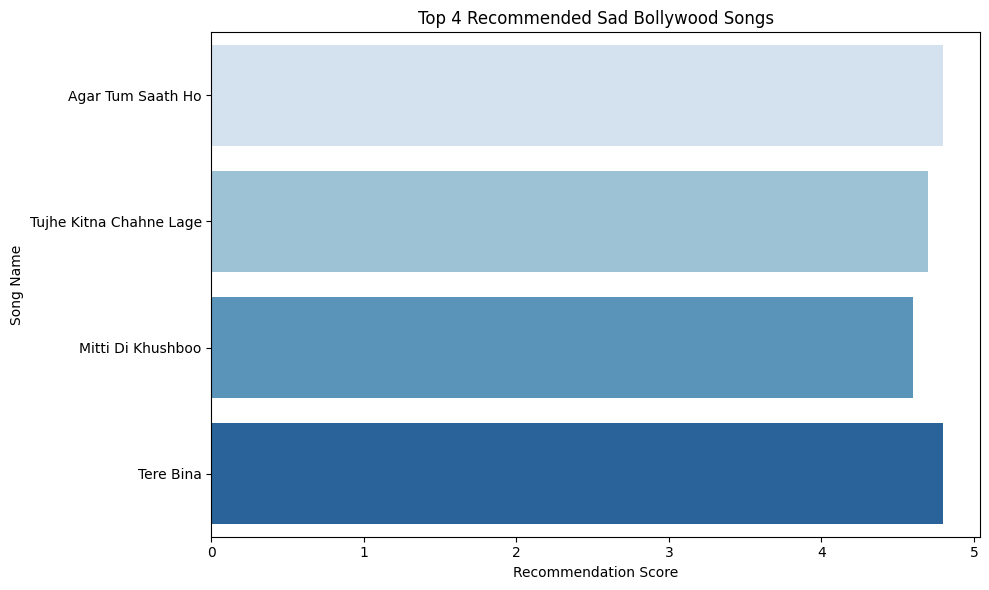

In [67]:
import matplotlib.pyplot as plt
import seaborn as sns

def plot_recommended_sad_songs(df_bollywood, n=5):
    # Filter for songs that are labeled as 'sad'
    sad_songs = df_bollywood[df_bollywood['genre'] == 'sad']

    # If there are fewer than 'n' sad songs, display all of them
    if len(sad_songs) < n:
        print(f"Only {len(sad_songs)} sad songs found.")
    
    # Plot the top 'n' sad Bollywood songs
    plt.figure(figsize=(10, 6))
    sns.barplot(x='score', y='song_name', data=sad_songs.head(n), palette='Blues')
    plt.title(f'Top {n} Recommended Sad Bollywood Songs')
    plt.xlabel('Recommendation Score')
    plt.ylabel('Song Name')

    # Do not add song names as text annotations
    # (Removed the part where song names were added as annotations)

    plt.tight_layout()
    plt.show()
# Example Bollywood song dataset including "sad" genre
df_bollywood = pd.DataFrame({
    'song_id': [1, 2, 3, 4, 5, 6],
    'song_name': ['Channa Mereya', 'Tum Hi Ho', 'Agar Tum Saath Ho', 'Tujhe Kitna Chahne Lage', 'Mitti Di Khushboo', 'Tere Bina'],
    'artist': ['Arijit Singh', 'Arijit Singh', 'Alka Yagnik', 'Arijit Singh', 'Neha Bhasin', 'A.R. Rahman'],
    'genre': ['romantic', 'romantic', 'sad', 'sad', 'sad', 'sad'],
    'score': [4.9, 4.5, 4.8, 4.7, 4.6, 4.8]
})

# Plot the top 5 recommended sad songs without song names on the bars
plot_recommended_sad_songs(df_bollywood, n=4)
